In [ ]:
!pip install ktrain

In [ ]:
import ktrain
from ktrain import text
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
edf = pd.read_csv('empathy.csv')

In [ ]:
edf = edf.dropna().reset_index(drop=True)

# empathetic_segments appears to be separated by |
# So I will split each record by that delimiter and then expand the dataframe such that there is only one empathic segment per row

split_es = [e.split('|') for e in edf.empathetic_segments]
split_es = [[str(segment) for segment in ses if segment] for ses in split_es]
edf['empathetic_segments'] = split_es
edf = edf.explode(['empathetic_segments']).dropna().reset_index(drop=True)

In [ ]:
# I will also combine the user post and the caregiver post as one so that the input is the total conversation and the output is an empathic segment from that exchange
# For contextual purposes I am renaming 'User' to 'Client'. However, this is malleable and can be modified as needed.
conv = [f'Client: {x}\nCaregiver: {y}' for x, y in zip(edf.user_post, edf.caregiver_post)]
edf['Conversation'] = conv

In [ ]:
edf['empathy_class '].value_counts()

6    1495
1    1067
4     418
2     176
5     117
3     107
Name: empathy_class , dtype: int64

In [ ]:
edf['segment_length'] = [len(x) for x in edf['empathetic_segments']]
edf.groupby('empathy_class ')['segment_length'].mean()

empathy_class 
1     76.564199
2     54.659091
3     26.925234
4     53.535885
5    117.358974
6    175.224080
Name: segment_length, dtype: float64

In [ ]:
edf[edf['segment_length'] > 350]['empathy_class '].value_counts()

6    141
1     11
5      5
Name: empathy_class , dtype: int64

In [ ]:
# Downsample on classes of 6, 4 and 1 to make the data classes more balanced
edf = edf[edf['segment_length'] < 350]

odf = edf[edf['empathy_class '] != 1]
odf = odf[odf['empathy_class '] != 6]
odf = odf[odf['empathy_class '] != 4]
df1 = edf[edf['empathy_class '] == 1].sample(frac=0.3)
df6 = edf[edf['empathy_class '] == 6].sample(frac=0.2)
df4 = edf[edf['empathy_class '] == 4].sample(frac=0.6)
empathy_df = pd.concat([odf, df1, df6, df4])
empathy_df = empathy_df.sample(frac=1).reset_index(drop=True)
empathy_df['empathy_class '].value_counts()

1    317
6    271
4    251
2    176
5    112
3    107
Name: empathy_class , dtype: int64

# Model 1 

In [ ]:
# Set empathy_class as string
e_class = [str(x) for x in empathy_df['empathy_class ']]
X_train, X_test, y_train, y_test = train_test_split(empathy_df['empathetic_segments'], e_class, test_size=0.15, random_state=78)

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=35)
trn = t.preprocess_train(list(X_train), np.array(y_train))
val = t.preprocess_test(list(X_test), np.array(y_test))
# model = t.get_regression_model()
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32)

preprocessing train...
language: en
train sequence lengths:
	mean : 15
	95percentile : 45
	99percentile : 61


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 16
	95percentile : 48
	99percentile : 60


simulating training for different learning rates... this may take a few moments...
Epoch 1/4
32/32 [==============================] - 12s 129ms/step - loss: 1.7982 - accuracy: 0.1475
Epoch 2/4
32/32 [==============================] - 4s 135ms/step - loss: 1.3882 - accuracy: 0.5118
Epoch 3/4
32/32 [==============================] - 4s 134ms/step - loss: 1.8851 - accuracy: 0.2362
Epoch 4/4
32/32 [==============================] - 2s 47ms/step - loss: 67.4119 - accuracy: 0.2006


done.
Visually inspect loss plot and select learning rate associated with falling loss


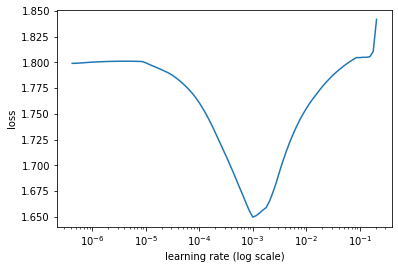

In [ ]:
learner.lr_find(show_plot=True, max_epochs=4)

In [ ]:
learner.autofit(1e-3)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/1024
33/33 [==============================] - 15s 197ms/step - loss: 1.3571 - accuracy: 0.5143 - val_loss: 1.0451 - val_accuracy: 0.6720
Epoch 2/1024
33/33 [==============================] - 5s 136ms/step - loss: 1.0973 - accuracy: 0.6279 - val_loss: 1.1229 - val_accuracy: 0.6129
Epoch 3/1024
33/33 [==============================] - ETA: 0s - loss: 1.0366 - accuracy: 0.6355
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 0.0005 (if not early_stopping).
33/33 [==============================] - 5s 136ms/step - loss: 1.0366 - accuracy: 0.6355 - val_loss: 1.0597 - val_accuracy: 0.6183
Epoch 4/1024
33/33 [==============================] - 5s 137ms/step - loss: 0.9030 - accuracy: 0.6956 - val_loss: 1.0461 - val_accuracy: 0.6882
Epoch 5/1024
33/33 [==============================] - ETA: 0s - 

In [ ]:
lp = ktrain.get_predictor(learner.model, preproc=t)

In [ ]:
preds = lp.predict(list(X_test))

In [ ]:
confusion_matrix(y_test, preds)

array([[37,  4,  0,  2,  1,  6],
       [ 7, 20,  0,  0,  0,  1],
       [ 1,  0,  0, 12,  0,  0],
       [ 3,  0,  0, 39,  0,  0],
       [ 9,  0,  0,  0,  0,  6],
       [ 7,  0,  0,  0,  1, 30]])

It's worth noting that from looking at the confustion matrix above, all of the category 3 values were either classified as class 1 or class 4. Digging a little deeper into this one can discover that the class 3 segments all appear to be very short, and in almost all cases, questions.

Also worth noting is that both class 3 and class 5 were the most under represented classes in the dataset.

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.58      0.74      0.65        50
           2       0.83      0.71      0.77        28
           3       0.00      0.00      0.00        13
           4       0.74      0.93      0.82        42
           5       0.00      0.00      0.00        15
           6       0.70      0.79      0.74        38

    accuracy                           0.68       186
   macro avg       0.47      0.53      0.50       186
weighted avg       0.59      0.68      0.63       186



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
lp.save('/content/drive/MyDrive/Supportiv/Supportiv_Models/Empathy_Segment_Classifier')